In [6]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 

import utils.sde_lib
import utils.models
import utils.losses as losses
from utils.datasets import get_dataset
import utils.samplers
from utils.misc import dotdict, batch_matrix_product

In [7]:
opts =  dotdict({
    'dataset': 'spiral',
    'lr' : 3e-4,
    'num_iters' : 1000,
    'batch_size' : 512, 
    
})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = get_dataset(opts)
dim = dataset.dim
model_backward = utils.models.MLP(dim=dim,augmented_sde=True).to(device=device)
model_forward = utils.models.MLP(dim=dim,augmented_sde=True).to(device=device)


itr=2000
model_path = f'./exp/momentum/itr_{itr}'

# model_path = f'./checkpoints/cld/itr_{itr}'
model_forward = utils.models.MatrixTimeEmbedding(4,2).to(device=device)
model_backward = torch.load(os.path.join(model_path,f'backward_ema_{itr}.pt'))
# model_forward = torch.load(os.path.join(model_path,f'forward_ema_{itr}.pt'))
sb = utils.sde_lib.LinearMomentumSchrodingerBridge()
# sb = utils.sde_lib.MomentumSchrodingerBridge()
cld = utils.sde_lib.CLD()
sb.backward_score = model_backward
sb.forward_score = model_forward
# sb.forward_score = lambda x,t : 0

In [8]:
from utils.misc import batch_matrix_product

t = torch.linspace(0,1,2, device=device).unsqueeze(0)
x = torch.ones((2,4), device=device)
x[:,-2:]*=3
print(.5 * sb.beta(t) * batch_matrix_product(-sb.D(t),x))
print(sb.drift(x,t,True))

tensor([[ 15.0000,  15.0000, -41.2858, -41.3953],
        [ 15.0000,  15.0000, -42.7264, -42.4521]], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor([[ 15.0000,  15.0000, -41.2858, -41.3953],
        [ 15.0000,  15.0000, -42.7264, -42.4521]], device='cuda:0',
       grad_fn=<MulBackward0>)


In [9]:
data = dataset.sample(1000).to(device=device)
# aug_data = torch.cat((data, torch.zeros_like(data)),dim=-1)
time_pts = torch.linspace(0,1,100, device=device)
backward = False


itr=2000
model_path = f'./checkpoints/spiral_sb/itr_{itr}'

# model_path = f'./checkpoints/cld/itr_{itr}'
model_backward = torch.load(os.path.join(model_path,f'backward_ema_{itr}.pt'))
model_forward = torch.load(os.path.join(model_path,f'forward_ema_{itr}.pt'))

sb = utils.sde_lib.SchrodingerBridge(backward_score=model_backward, forward_score=model_forward)

in_cond = sb.prior_sampling(shape=(*data.shape,),device=data.device) if backward else data
xt, trajectory, not_learned_policies = sb.get_trajectories_for_loss(in_cond, time_pts,forward=not backward)
trajectory = trajectory.detach()

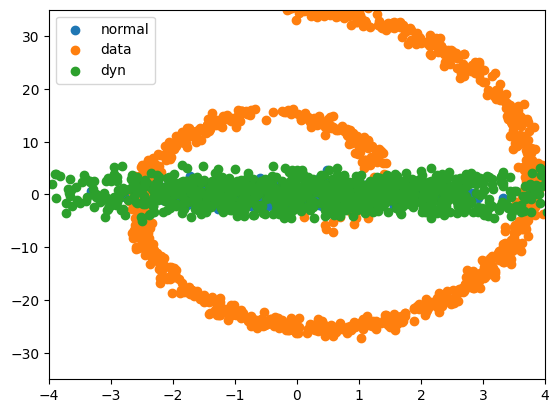

In [10]:
data = dataset.sample(1000).to(device=device)
aug_data = torch.cat((data, torch.zeros_like(data)),dim=-1)

# noise, trajectory = cld.sample((1000,4),device,False, in_cond=aug_data)
rand = torch.randn_like(xt)
for i in range(trajectory.shape[1]):
    plt.close()
    plt.xlim(-4,4)
    plt.ylim(-35,35)
    plt.scatter(rand[:,0].cpu(),rand[:,1].cpu(),label='normal')
    plt.scatter(aug_data[:,0].cpu(),aug_data[:,1].cpu(),label='data')
    plt.scatter(trajectory[:,i,0].cpu(),trajectory[:,i,1].cpu(),label='dyn')
    plt.legend()
    plt.savefig(f'trajectory/{i}.png')